In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
counts_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/ecol/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TASEP-KS/ecol/'
mutation = 'efp'
samp_num = '2'

# figure out if the notebook has already been done for this dataset and only run the
# visualizations. 
if os.path.isfile(save_path + "TASEP_ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Define functions

In [5]:
def load_count_positions_v2(csv_name, counts_path):
    data = []
    gene_names = []
    with open(counts_path + csv_name, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    blank=data.pop(0)
            
    for i,ii in zip(data, range(len(data))):
        for j,jj in zip(i, range(len(i))):
            try:
                x = int(float(j))
                data[ii][jj] = x
            except:
                pass
            
    # Remove empty space
    for i,ii in zip(data, range(len(data))):
        x = list(filter(('').__ne__, i))
        data[ii] = x
        
    # Convert lists to np.arrays
    for i,ii in zip(data, range(len(data))):
        gene_names.append(data[ii][1])
        data[ii] = np.array(data[ii][2:])
    
    return data, gene_names

In [6]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(transcript):
    transcript = transcript + 1 #All elongation rates were calculated this way to set a new baseline
    M = sum(transcript)
    p = transcript/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

## Loading up the csv file.

In [7]:
# Load in the count positions data.
data_mutant, names_mutant = load_count_positions_v2(mutation+"_"+samp_num+"_counts.csv",counts_path)
data_control, names_control = load_count_positions_v2("control_"+ samp_num +"_counts.csv",counts_path)

In [8]:
# Load in the elongation rates data.
elon_mutant = kat.load_elongation_rates(mutation + '_' + samp_num + '_elongation_rates', elon_path)
elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

## Tasep-KS method

In [9]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    alt_p_list = []
    pbar_m_list = []
    pbar_c_list = []
    gene_list = []
    for tr_m, tr_c, el_m, el_c, gene_name in zip(data_mutant, data_control, elon_mutant, elon_control, names_mutant):
        if len(tr_m) > 100 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            alt_p_list.append(kat.alter_p(el_c, el_m))
            pbar_m_list.append(get_pbar_from_count(tr_m))
            pbar_c_list.append(get_pbar_from_count(tr_c))
            gene_list.append(gene_name)

In [10]:
max_pool = 20

if pre_load == False:
    with Pool(max_pool) as p:
        pool_alt_p = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       alt_p_list),
                total=len(alt_p_list)
            )
        )    

100%|██████████████████████████████████████████████████████████████████████████████████| 2320/2320 [00:03<00:00, 629.43it/s]


In [11]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_pbar_m = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       pbar_m_list),
                total=len(pbar_m_list)
            )
        )    

100%|██████████████████████████████████████████████████████████████████████████████████| 2320/2320 [00:03<00:00, 614.58it/s]


In [12]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_pbar_c = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       pbar_c_list),
                total=len(pbar_c_list)
            )
        )    

100%|██████████████████████████████████████████████████████████████████████████████████| 2320/2320 [00:03<00:00, 624.95it/s]


In [13]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_m_list = []
    ks_c_list = []
    ks_diff_list = []
    for pbar_m, pbar_c, alt_p in zip(pool_pbar_m, pool_pbar_c, pool_alt_p):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            sm_m, cumul_m = pbar_m
            sm_c, cumul_c = pbar_c
            sm_p, cumul_p = alt_p
            for d, i in zip(sm_m, list(range(len(sm_m)))):
                if d < 0:
                    sm_m[i] = 0.000000000000000000001
            ks_m = max(abs(cumul_p - cumul_m))
            ks_c = max(abs(cumul_p - cumul_c))
            ks_diff = ks_c - ks_m
            ks_m_list.append(ks_m)
            ks_c_list.append(ks_c)
            ks_diff_list.append(ks_diff)
            
    # reorganizing the lists into a dataframe. 
    df_t = pd.DataFrame(list(zip(gene_list,ks_m_list, ks_c_list, ks_diff_list)))
    df_t.columns = ["gene_ID","ks_mutant", "ks_control", "ks_diff"]
    df_t.to_csv(save_path + "TASEP_ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_m_list.clear()
    ks_c_list.clear()
    ks_diff_list.clear()

In [14]:
if pre_load == True:
    df_t = pd.read_csv(save_path2 + "TASEP_ks_table_" + samp_num + ".csv")

Text(0.5, 1.0, 'KS difference (control - mutant)')

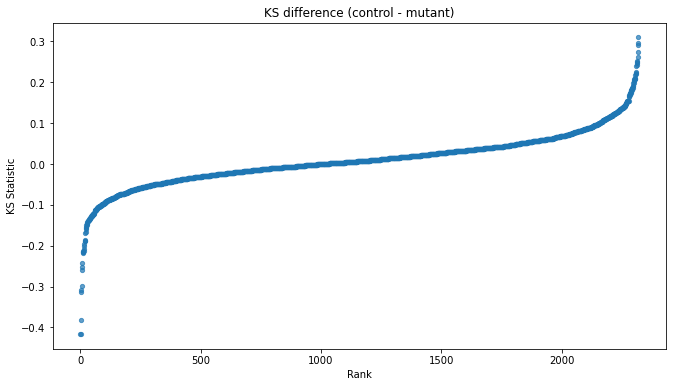

In [15]:
figure(figsize = (11,6))
plt.scatter(list(range(len(df_t["ks_diff"]))), sorted(df_t["ks_diff"]), s=18, alpha = 0.7)
plt.ylabel("KS Statistic")
plt.xlabel("Rank")
plt.title("KS difference (control - mutant)")

In [16]:
group = df_t[(df_t['ks_diff'] > 0.25)].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['ks_diff'].unique())

In [17]:
len(diff_dist)

7

In [18]:
def big_dif(diff_dist, gene_names, data_mutant, data_control, figsize = (16,50), fontsize = 12, stat_name = "ks_stat ="):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, stat, gi in zip(ax, diff_dist, diff_dist.index):
        for tr_m, tr_c, name in zip(data_mutant, data_control, gene_names):
            if gi == name:
                my_vec_mutant = tr_m
                my_vec_control = tr_c
                maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

                axi[0].plot(my_vec_mutant)
                axi[0].text(len(my_vec_mutant)/2, maxi/1.2, stat_name + str(stat), fontsize = fontsize)
                axi[0].set_ylim([0,maxi])
                axi[0].set_ylabel("Read Counts", fontsize = fontsize)
                axi[0].set_xlabel("Codon Position", fontsize = fontsize)
                axi[0].set_title("mutant " + gi, fontsize = fontsize)
                axi[1].plot(my_vec_control)
                axi[1].set_ylim([0,maxi])
                axi[1].set_ylabel("Read Counts", fontsize = fontsize)
                axi[1].set_xlabel("Codon Position", fontsize = fontsize)
                axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()
            
    return ax

def big_dif_smoothed(diff_dist, gene_names, data_mutant, data_control, figsize = (16,50), fontsize = 12, stat_name = "ks_stat ="):
    '''
    A function which creates a large graph showing the smoothed profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, stat, gi in zip(ax, diff_dist, diff_dist.index):
        for tr_m, tr_c, name in zip(data_mutant, data_control, gene_names):
            if gi == name:
                my_vec_mutant = tr_m
                my_vec_control = tr_c
                sm_m, cumul_m = kat.get_smoothed_vector(my_vec_mutant)
                sm_c, cumul_c = kat.get_smoothed_vector(my_vec_control)
                maxi = max([max(sm_m), max(sm_c)])*1.1
                axi[0].plot(sm_m)
                axi[0].text(len(sm_m)/2, maxi/1.2, stat_name + str(stat), fontsize = fontsize)
                axi[0].set_ylim([0,maxi])
                axi[0].set_ylabel("Read Counts", fontsize = fontsize)
                axi[0].set_xlabel("Codon Position", fontsize = fontsize)
                axi[0].set_title("mutant " + gi, fontsize = fontsize)
                axi[1].plot(sm_c)
                axi[1].set_ylim([0,maxi])
                axi[1].set_ylabel("Read Counts", fontsize = fontsize)
                axi[1].set_xlabel("Codon Position", fontsize = fontsize)
                axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()
            
    return ax

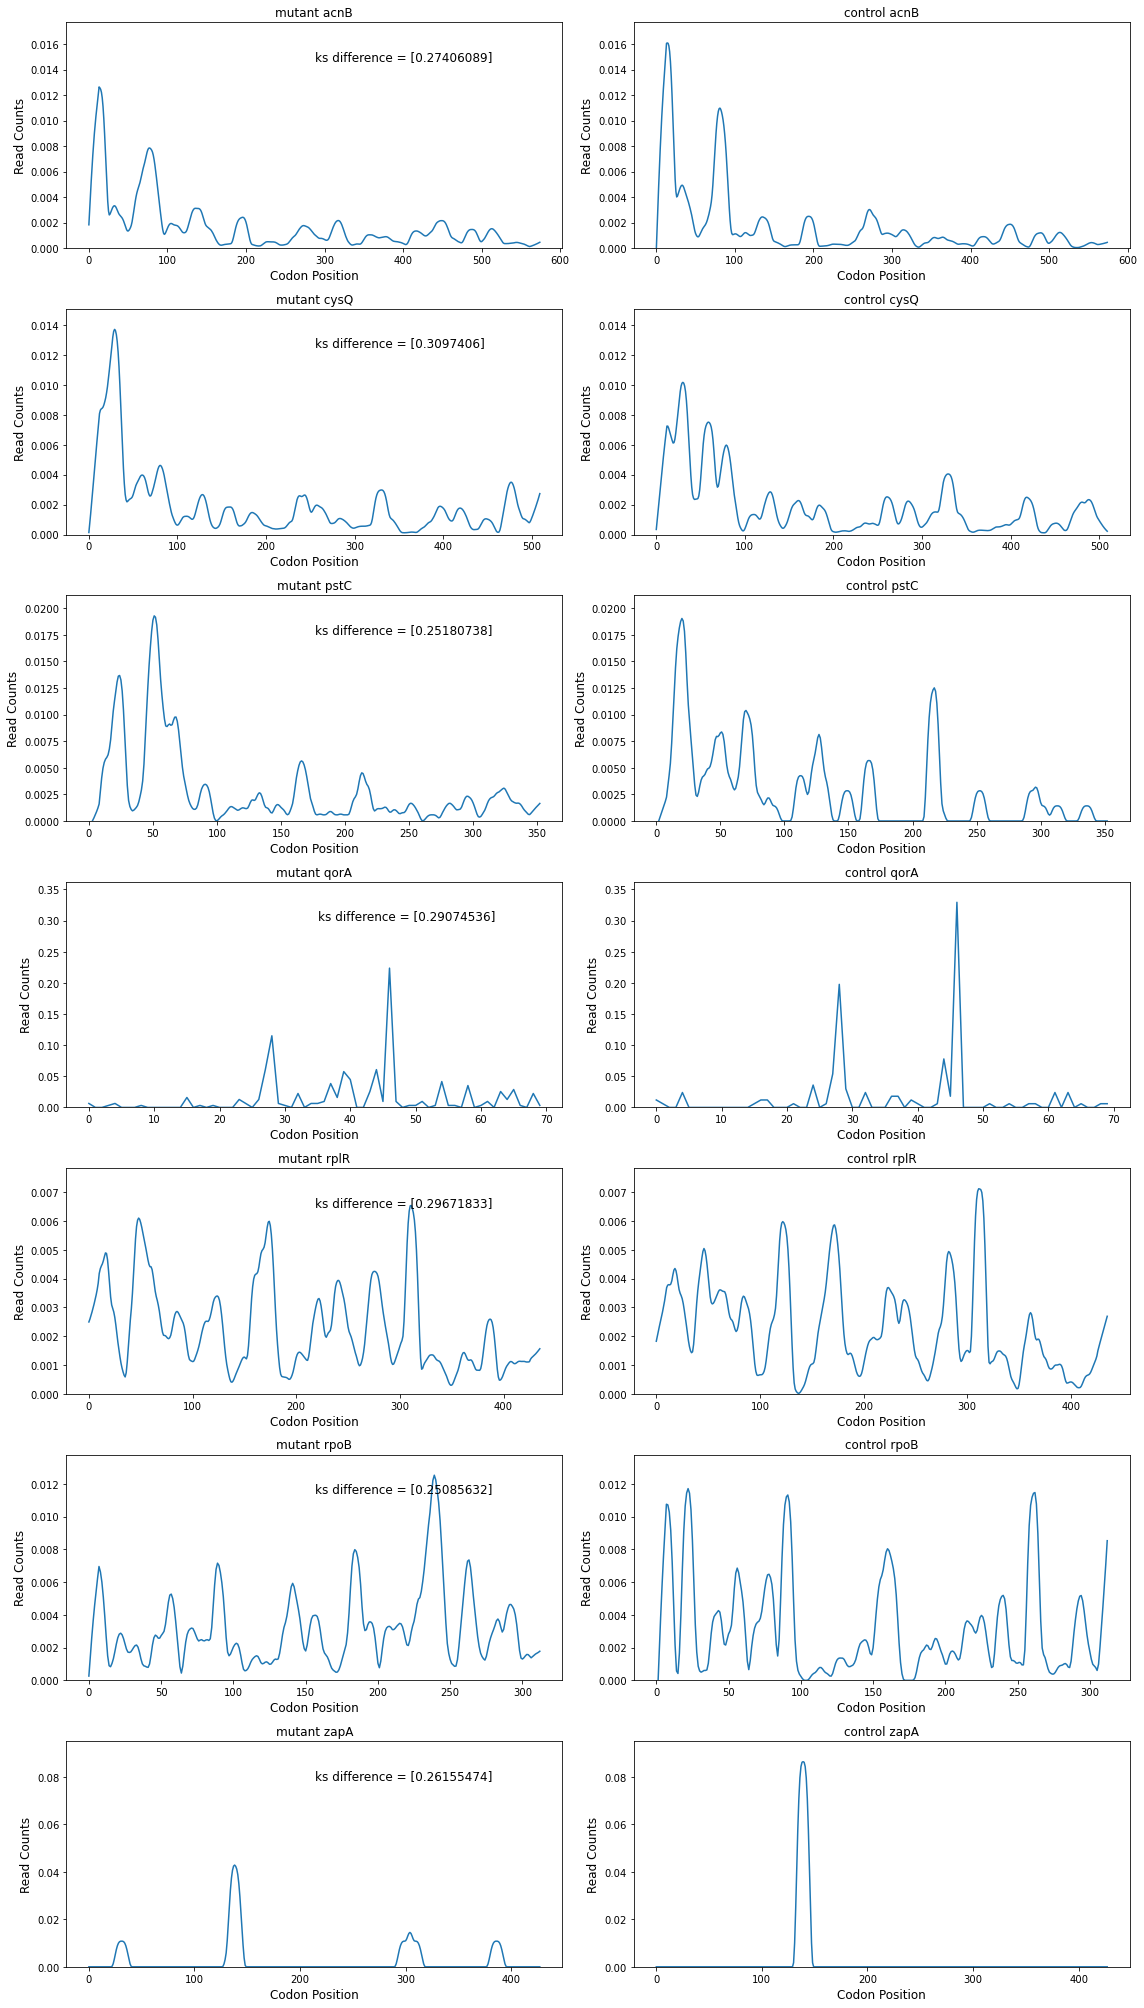

In [19]:
ax = big_dif_smoothed(diff_dist, gene_list, data_mutant, data_control, figsize = (16,len(diff_dist)*4), 
                          fontsize = 12, stat_name = "ks difference = ")